Inspired and derived from work of Chan Nantasenamat 

In [ ]:
! conda install -c conda-forge rdkit
#import sys
#sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [25]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style = 'ticks')
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [2]:
df = pd.read_csv('bioactivity_preprocessed_data.csv')

Examining pharmacokinetic profile based on on the ADME. We can preform evaluation of druglikeness of compounds using Rule-of-Five (Lipinski's Rule).

Lipinski Rule states:
    Molecular weight < 500 Dalton,
    Octanol-water partition coefficient (LogP) < 5,
    Hydrogen bond donars < 5,
    Hydrogen bond acceptors < 5

In [3]:
# Inspired by https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata = []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)
    baseData=np.arange(1,1)
    i=0
    for mol in moldata:
        
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
        
        row = np.array([desc_MolWt, 
                        desc_MolLogP, 
                        desc_NumHDonors, 
                        desc_NumHAcceptors])
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1
        
    columnNames = ['MW', 'LogP', "NumHDonors", 'NumHAcceptors']
    descriptors = pd.DataFrame(data=baseData, columns=columnNames)
    
    return descriptors

Calculate descriptors

In [4]:
df_lipinski = lipinski(df.canonical_smiles)

In [53]:
df_lipinski.head(3)

,MW,LogP,NumHDonors,NumHAcceptors
0,281.271,1.89262,0.0,5.0
1,415.589,3.81320,0.0,2.0
2,421.190,2.66050,0.0,4.0


## Combine DataFrames

In [7]:
df_combined = pd.concat([df, df_lipinski], axis=1)

In [8]:
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate,281.271,1.89262,0.0,5.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate,415.589,3.81320,0.0,2.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive,421.190,2.66050,0.0,4.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0,inactive,293.347,3.63080,0.0,3.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0,intermediate,338.344,3.53900,0.0,5.0
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,10600.0,inactive,338.359,3.40102,0.0,5.0
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,10100.0,inactive,296.366,3.44330,0.0,3.0
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,11500.0,inactive,276.291,4.09564,0.0,3.0
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,10700.0,inactive,278.307,3.29102,0.0,3.0


### Convert IC50 to pIC50

Need IC50 to be more uniformly distributed, so we convert to negative logarithmic scale

The below function will take **standard_value** from df and convert from nM to M, molecular value and apply -log10, and replace the column with new pIC50

In [16]:
# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb

def pIC50(input):
    pIC50 = []
    
    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))
        
    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
    
    return x

In [17]:
df_combined.standard_value.describe()

count    1.330000e+02
mean     8.017926e+12
std      3.344888e+13
min      5.000000e+01
25%      1.070000e+04
50%      2.350000e+04
75%      3.000000e+05
max      3.311311e+14
Name: standard_value, dtype: float64

Must cap the value of that is in **standard_value** to be 100,000,000 otherwise the negative logarithmic value will becomes negative

In [18]:
def norm_value(input):
    norm = []
    
    for i in input['standard_value']:
        if i > 100000000:
            i = 100000000
        norm.append(i)
    
    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
    
    return x

Apply the above function to **standard_normal**

In [19]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediate,281.271,1.89262,0.0,5.0,7200.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediate,415.589,3.81320,0.0,2.0,9400.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,13500.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,13110.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediate,338.344,3.53900,0.0,5.0,2000.0
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0.0,5.0,10600.0
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0.0,3.0,10100.0
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0.0,3.0,11500.0
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0.0,3.0,10700.0


In [20]:
df_norm.standard_value_norm.describe()

count    1.330000e+02
mean     2.110164e+07
std      4.089714e+07
min      5.000000e+01
25%      1.070000e+04
50%      2.350000e+04
75%      3.000000e+05
max      1.000000e+08
Name: standard_value_norm, dtype: float64

In [23]:
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediate,281.271,1.89262,0.0,5.0,5.142668
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediate,415.589,3.81320,0.0,2.0,5.026872
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,4.882397
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediate,338.344,3.53900,0.0,5.0,5.698970
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0.0,5.0,4.974694
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0.0,3.0,4.995679
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0.0,3.0,4.939302
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0.0,3.0,4.970616


Remove the 'intermediate' bioactivity class

In [24]:
df_2class = df_final[df_final.bioactivity_class != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,4.882397
5,CHEMBL365134,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c(Br)cccc21,active,372.243,4.39330,0.0,3.0,6.008774
7,CHEMBL190743,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccc(I)cc21,active,419.243,4.23540,0.0,3.0,6.022276
8,CHEMBL365469,O=C1C(=O)N(Cc2cc3ccccc3s2)c2cccc(Cl)c21,inactive,327.792,4.28420,0.0,3.0,4.950782
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0.0,5.0,4.974694
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0.0,3.0,4.995679
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0.0,3.0,4.939302
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0.0,3.0,4.970616


### Exploratory Data Analysis - Chemical Space Analysis

Frequency plot of two bioactivity classes

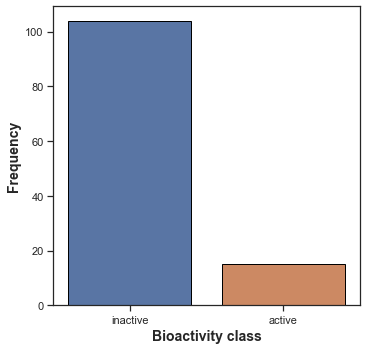

In [26]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

### Scatter plot of MW versus LogP

Both bioactivity classes span similar chemical spaces as seen below

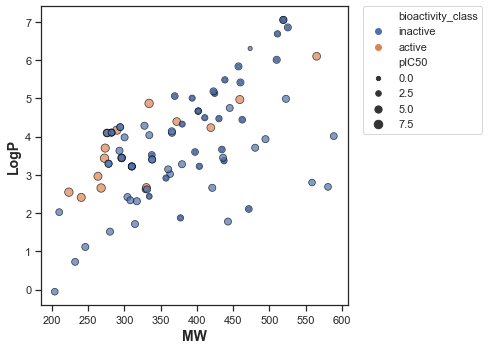

In [29]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

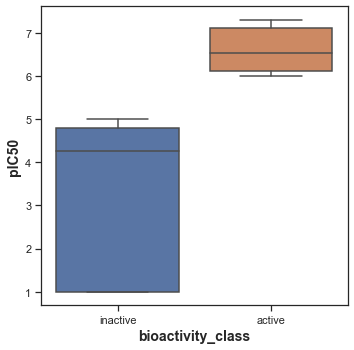

In [31]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x='bioactivity_class', y='pIC50', data=df_2class)

plt.xlabel('bioactivity_class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50', fontsize=14, fontweight='bold')
plt.savefig('plot_ic50.pdf')

### Statistical Analysis using Mann-Whitney U Test

In [38]:
def mannwhitney(descriptor, verbose=False):
    # https://machinelearningmaster.com/nonparametric-statistical-significance-tests-in-python/
    from numpy.random import seed
    from numpy.random import randn
    from scipy.stats import mannwhitneyu
    
    # seed the random number generator
    seed(1)
    
    # actives and inactives
    selection = [descriptor, 'bioactivity_class']
    df = df_2class[selection]
    active = df[df.bioactivity_class == 'active']
    active = active[descriptor]
    
    selection = [descriptor, 'bioactivity_class']
    df = df_2class[selection]
    inactive = df[df.bioactivity_class == 'inactive']
    inactive = inactive[descriptor]
    
    # compare samples
    stat, p = mannwhitneyu(active, inactive)
    #print('Statistics=%.3f, p=%.3f' % (stat, p))
    
    # interpret
    alpha = 0.05
    if p > alpha:
        interpretation = 'Same distribution (fail to reject H0)'
        
    else:
        interpretation = 'Different distribution (reject H0)'
        
    results = pd.DataFrame({'Descriptor': descriptor,
                           'Statistics': stat,
                           'p':p,
                           'alpha':alpha,
                           'Interpretation':interpretation}, index=[0])
    filename = 'mannwhitneyu_' + descriptor + '.csv'
    results.to_csv(filename)
    
    return results
    
    

In [39]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,0.0,1.662636e-10,0.05,Different distribution (reject H0)


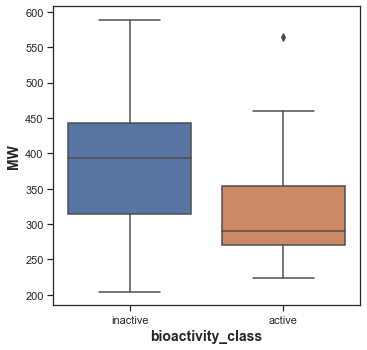

In [46]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x='bioactivity_class', y='MW', data=df_2class)

plt.xlabel('bioactivity_class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

In [41]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,409.5,0.001525,0.05,Different distribution (reject H0)


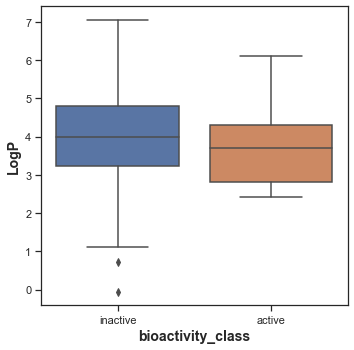

In [45]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x='bioactivity_class', y='LogP', data=df_2class)

plt.xlabel('bioactivity_class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [44]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,712.5,0.295805,0.05,Same distribution (fail to reject H0)


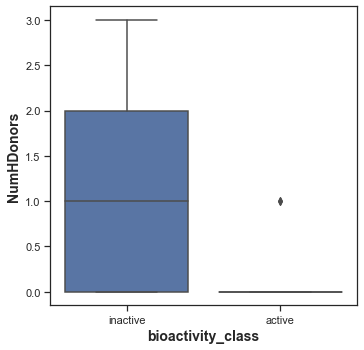

In [51]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x='bioactivity_class', y='NumHDonors', data=df_2class)

plt.xlabel('bioactivity_class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

In [48]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,299.5,0.000024,0.05,Different distribution (reject H0)


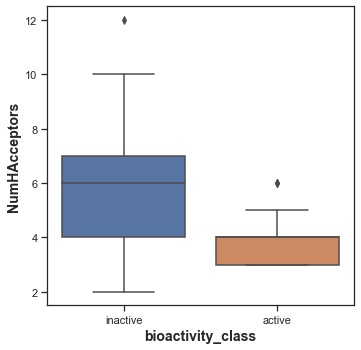

In [50]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x='bioactivity_class', y='NumHAcceptors', data=df_2class)

plt.xlabel('bioactivity_class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [52]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,415.0,0.001557,0.05,Different distribution (reject H0)


### Interpretation of Statistical Results

Box Plots



For the pIC50 values, the actives and inactives display statisticall differences since threshold values were used to define actives and inactives.

Lipinski's descritors

Of the 4 Lipinski's descriptors (MW, LogP, NumHDonors and NumHAcceptors), only LogP exhibited no difference between the actives and inactives

While the three others show statistically significant differences between actives and inactives